#  <span style="color:blue">Exercise 3 - Driver file </span>
## <span style="color:blue">Computer Vision - Fall 2021


**Lecturer:** Prof. Yael Moses, IDC

**TA:** Eyal Friedman, IDC

In this assignment you will practice working with videos, and simple segmentations.
    
**Submission date: 3.1.2022**\
Note: in case you need an extenstion for any reason - you can submit it by 9.1.22, but we will not be able to grade it before the exam. No extra extensions will be given.

## Submission guidelines:

1. Your **zip** should include the following files only:
    - ex3.ipynb  (**Or**  ex3.py for students who refuses to work with Jupiter Notebook). 
    - ex3_ID_ID.pdf (If you decieded not to answer on some of the questions in the notebook, you should submit it as a pdf file). 
   (Don't add the python code to that file.)
    
2. You may use any IDE as you want (Spyder, Jupyter Notebook, Pycharm, ect.).
3. Name the zip file **'ex3_ID_ID.zip'** and **do not** include any additional directories. 
4. Submit using *moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets)
- **Important - if you submit in pairs, one should submit the howework and the other should submit a simple text file named: ID_ID.txt and nothing else.**

## Read the following instructions carefully:
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests, unless requested.
3. Use `python 3` and `numpy 1.18.5`. Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden, unless been provided by us.
4. Your code must run without errors. Note,  **code that fails to  run will not be graded.**
5. Document your code properly.

## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the Web. However, if  you do so, then you will not learn what you should learn from it. In addition, since we  grade  the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solves the task. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.


In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from scipy.signal import convolve, convolve2d

In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.9.7
Numpy version:  1.21.4


## Section A: Change Detection

**A1. Simple change detection**

Compute a simple change detection algorithm. Use as background the median of a set of k1 frames, and update it every k2 frames. Your algorithm should work on color images. Think how to merge the different channels (colors). You can assume that the camera is static. The output is a video where the pixels of the  foreground objects consists of the original frame, and the other pixels are black. 

*Input:* video, k1, k2, and any other parameter you would like to add\
im: a grey level or an RGB image\
k1: the number of frames for computing the median\
k2: the number of frames between two updates of the background

*output:*  v_foreground

In [3]:
def median_change_dection(video, k1, k2, th, rgb=False):
    frame_n = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    mapper = cv2.COLOR_BGR2RGB if rgb else cv2.COLOR_BGR2GRAY 
    frames = np.array([cv2.cvtColor(video.read()[1], mapper) for _ in range(frame_n)])
    background = []
    
    for i in range(frame_n):
        if i % k2 == 0: 
            img = np.median(frames[i:k1+i], axis=0)
        background.append(img)
        
    distance = np.abs(frames - background).astype(int)
    frames[distance.mean(axis=3)<th] = 0  # We choose to average the RGB
    
    return frames

Load original image and generate the foreground

In [4]:
vid = cv2.VideoCapture('SLIDE.avi')
v_foreground = median_change_dection(vid, 20, 20, 40, True)

Load the original image again (as we already read all frames)

In [5]:
vid = cv2.VideoCapture('SLIDE.avi')
v_original = np.array([cv2.cvtColor(vid.read()[1], cv2.COLOR_BGR2RGB) for _ in range(int(vid.get(cv2.CAP_PROP_FRAME_COUNT)))])

We now compare the foreground with the original image at a specific frame that you can set.

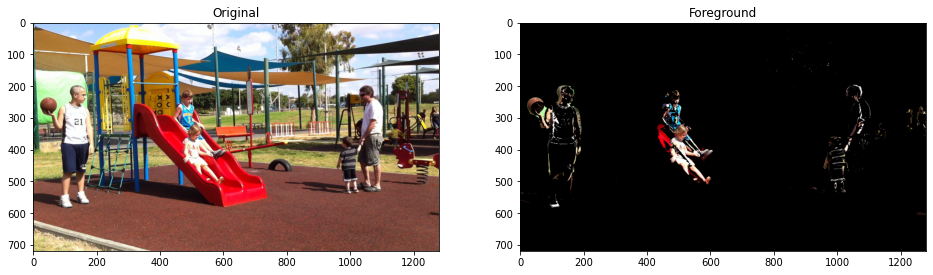

In [6]:
frame = 55
fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(v_original[frame]), ax[0].set_title('Original')
ax[1].imshow(v_foreground[frame]), ax[1].set_title('Foreground');

In [7]:
writer = cv2.VideoWriter(filename="my_video.avi",  #Provide a file to write the video to
fourcc=cv2.VideoWriter_fourcc(*'mp4v'),            #Use whichever codec works for you...
fps=30,                                        #How many frames do you want to display per second in your video?
frameSize=(1280, 720)) 

In [9]:
# for i in v_PP_foreground:
#     writer.write(i)
# writer.release()

**A2. Post Processing for change detection**

**Answer:** Suggest a post processing algorithm for improving  the results of a change detection algorithm (e.g., remove noise or fill gaps). 

**Code:** implement your algorithm.

*Input:*  v_original, v_foreground\
v_original: the original video\
v_foreground: the output of A1

*output:* v_PP_foreground\
v_PP_foreground: the result of the post processing on v_foreground.


**Note:**
1. You may want to generate from v_foreground  a binary mask of the foreground regions.
2. You can use dilation or erosion on a the binary mask.
3.  You may use additional frames to improve the results, but you do not have to.


**Answer:**

In order to fill the gaps, we dilate all the foreground frames, where the dilation strength is left as a parameter. We then transform the frames to binary frames.<br>
For each frame, we keep all connected components which their counts reached a certain threshold (as a function of the dilation strengh). Then, we use that as a filtering mask for the original video input.

Notice that we used 3d convolution instead of dilating each frame.

In [10]:
imgg = convolve(v_foreground[frame], np.ones((10,10,1)), mode='same').astype(int)

In [11]:
imgg[imgg>0] = 255

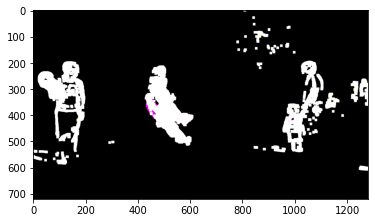

In [12]:
plt.imshow(imgg)

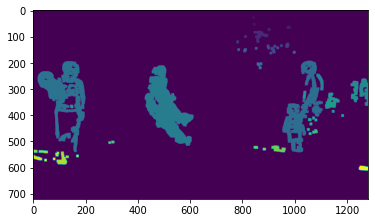

In [13]:
connected_mat = cv2.connectedComponents(imgg[:,:,0].astype(np.uint8), connectivity=8)[1]
plt.imshow(connected_mat)

In [ ]:
components, counts = np.unique(connected_mat, return_counts=True)
connected_mat[np.isin(connected_mat,components[counts<2000])] = 0

In [ ]:
plt.imshow(connected_mat)

In [ ]:
tst = v_original[frame] + 0
tst[connected_mat == 0] = 0
plt.imshow(tst)

In [17]:
img_big = convolve(v_foreground, np.ones((1,15,15,1)), mode='same').astype(int)

In [18]:
img_big[img_big > 0] = 255

In [19]:
v_PP_foreground = np.empty_like(v_foreground, dtype=np.uint8)
for i in range(len(img_big)):
    connected_mat = cv2.connectedComponents(img_big[i,:,:,0].astype(np.uint8), connectivity=8)[1]
    components, counts = np.unique(connected_mat, return_counts=True)
    connected_mat[np.isin(connected_mat,components[counts<2000])] = 0
    tmp = v_original[i] + 0
    tmp[connected_mat == 0] = 0
    v_PP_foreground[i] = tmp

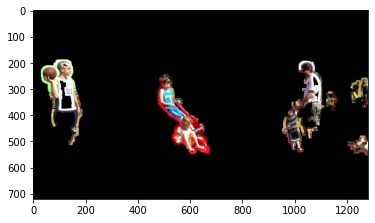

In [20]:
plt.imshow(v_PP_foreground[66])

In [4]:
def improve_foreground(v_original,v_foreground, dil_strengh=10):
    dilated_v_original = convolve(v_foreground, np.ones((1,dil_strengh,dil_strengh,1)), mode='same').astype(int)
    dilated_v_original[dilated_v_original > 0] = 1  # for binary frames
    v_PP_foreground = np.empty_like(v_foreground, dtype=np.uint8)
    for i in range(len(dilated_v_original)):
        connected_mat = cv2.connectedComponents(dilated_v_original[i,:,:,0].astype(np.uint8), connectivity=8)[1]
        components, counts = np.unique(connected_mat, return_counts=True)
        connected_mat[np.isin(connected_mat,components[counts<dil_strengh*200])] = 0
        tmp = v_original[i] + 0
        tmp[connected_mat == 0] = 0
        v_PP_foreground[i] = tmp
    return v_PP_foreground

In [22]:
v_PP_foreground = improve_foreground(v_original, v_foreground, 13)

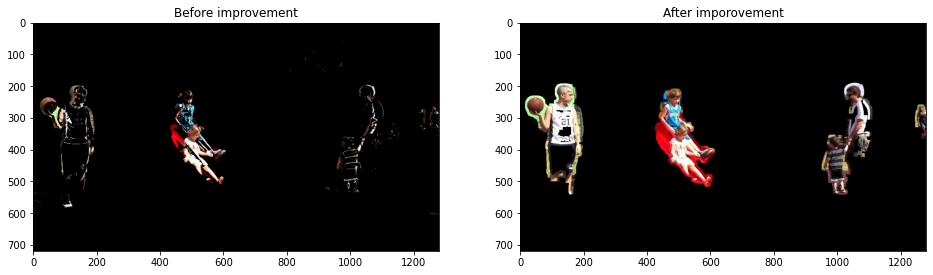

In [23]:
frame = 55
fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(v_foreground[frame]), ax[0].set_title('Before improvement')
ax[1].imshow(v_PP_foreground[frame]), ax[1].set_title('After imporovement');

# Section B: Compute Optical Flow (OF) using Lucas-Kanade

**B1. Basic Lucas Kanade OF**

Impelment the basic Lucas-Kanade we leared in class.

*Input:*  name_file, nf1, nf2,  region_size, sigma_S\
name_file: a name of a video file\
f1 and f2: the numbers of the two frames form the video on which the OF is computed.\
sigma_S: the variance of the Gaussian used for the  spatial smoothing  as in HW1 (for computing the derivative of a Gaussian).\
region_size, $R$: the $R\times R$ the region windows for computing the matrix $C$ (see class 7, slide 58).

*Output:* U, V, im1,im2\
U, V:  two matrices with the x and y motion for each pixel, respectively.\
im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).

**Note:**
1. You can use any video reading method you find convenient.
2. Do not forget to convert the images into grey scale.
3. You can compute the derivatives of the images as in HW1 - convolution with the derivative of a Gaussian.
3. You can resize the images in order for the program to run faster.
5. The computed OF is not necessarily integers. You may want to perform float computation.

In [5]:
def Create_Matrices(sig):
    """
    Creates 2 matrices for gaussian kernel
    with size l x l and a sigma 'sig'
    Note: l should be odd. Otherwise, l is increased by 1.
    """
    l = int(round(sig*4))
    if (l % 2) == 0: l=l+1  
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    return xx, yy


def Deriv_Gauss_x(sig, xx, yy):
    """
    Creates gaussian kernel in x direction 
    """
    calc_gauss_derv_x = lambda x, y, sig: (-x/2*np.pi*sig**4)*np.exp((x**2+y**2)/2*sig**2)   
    kernel = calc_gauss_derv_x(xx, yy, sig)
    
    return kernel


def Deriv_Gauss_y(sig, xx, yy):
    """
    Creates gaussian kernel in y direction
    """
    calc_gauss_derv_y = lambda x, y, sig: (-y/2*np.pi*sig**4)*np.exp((x**2+y**2)/2*sig**2)   
    kernel = calc_gauss_derv_y(xx, yy, sig)
    
    return kernel

def Grad_x(img, G_dx):
    """
    Convolve img with x direction Gaussian mask
    """
    resultConv = convolve2d(img, G_dx, mode='same')

    return resultConv


def Grad_y(img, G_dy):
    """
    Convolve img with y direction Gaussian mask
    """
    resultConv = convolve2d(img, G_dy, mode='same')

    return resultConv


def gaussian_mask(sig=0.5):
    """
    Creates gaussian kernel with length l and sigma 'sig'
    """
    l = int(round(sig*4))
    if (l % 2) == 0: l=l+1
        
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)
    kernel = 0.5*(1/np.pi*sig)*np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

def apply_gaussian_mask(image, mask):
    return convolve2d(image, mask, mode='same')

In [6]:
def LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, patch_size, move):
    """
    Implement Lucas-Kanade algorithem
    :param name_file: file path of the video
    :param nf1: index of frame 1
    :param nf2: index of frame 2
    :param sigma_S: std of the gussian mask to smooth the frames
    :param sigma_R: std of the gussian mask to help compute C
    :param patch_size: a patch size
    :param move: the distance between tow centers of patches
    :param return U, V: two matrices with the x and y motion for each pixel, respectively.
    :param return im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).
    """
    
    # Converting the video to farmes
    vls = Video_To_Grey_list(name_file)  # Replace that

    print(nf1)
    print(len(vls))
    # Choosing frames nf1 and nf2
    f1 = vls[nf1]/255
    f2 = vls[nf2]/255
    
    # Setting Ix and Iy
    xx, yy = Create_Matrices(sigma_S) 
    G_dx = Deriv_Gauss_x(sigma_S, xx, yy)
    G_dy = Deriv_Gauss_y(sigma_S, xx, yy)
    Ix = Grad_x(f1, G_dx)
    Iy = Grad_y(f1, G_dy)
    Ix = Ix/Ix.max()
    Iy = Iy/Iy.max()
       
    # Setting It
    num = 3
    kernel_t = np.ones((num, num))/num**2
    It = convolve2d(f1, kernel_t, mode='same') + convolve2d(f2, -kernel_t, mode='same')
    It = It/It.max()
        
    # Parameters in order to compute C
    R_mask = gaussian_mask(sigma_R)
    IxxG = convolve2d((Ix**2), R_mask)
    IyyG = convolve2d((Iy**2), R_mask)
    IxyG = convolve2d((Iy*Ix), R_mask)
    C = np.zeros((2,2)) 

    # Setting U and V
    U = np.zeros(Ix.shape)
    V = np.zeros(Ix.shape)
    k = 0.05
    patch = patch_size//2

    for row in range(patch+1, f1.shape[0]-patch-1, move):
        for col in range(patch+1, f1.shape[1]-patch-1, move):
            
            # Setting the patches
            patch_x= Ix[row-patch:row+patch+1, col-patch:col+patch+1]
            patch_y= Iy[row-patch:row+patch+1, col-patch:col+patch+1]
            patch_t= It[row-patch:row+patch+1, col-patch:col+patch+1]
            
            # Computing A, B, C
            A =  np.vstack((patch_x.flatten(), patch_y.flatten())).T
            B = patch_t.flatten().T
            C[0,0] = IxxG[row, col]
            C[0,1] = IxyG[row, col]
            C[1,0] = IxyG[row, col]
            C[1,1] = IyyG[row, col]
            
            # Finding the ranks of C in the same way like in harris corner detector
            determinate = C[0,0]*C[1,1] - C[0,1]*C[1,0]
            traceC = C[0,0] + C[1,1]
            R = determinate - k * traceC ** 2
 
            if R > 0:
                
                "Cinv is (AT*A)^-1"
                Cinv = np.linalg.inv(C)
                Cinv = Cinv/Cinv.max() 
                
                A_P = Cinv@A.T
                A_PB = A_P@B
                U[row,col] = A_PB[0]
                V[row,col] = A_PB[1]             
    
    return U, V, f1, f2

In [7]:
name_file = 'SLIDE.avi'
nf1 = 70
nf2 = 73
sigma_S = 2
sigma_R = 3

U, V, im1, im2 = LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, 10, 1)

NameError: name 'Video_To_Grey_list' is not defined

**B2. Present OF results**

*Input:* im1, U, V (the output of LK_OF without im2).

*Output:* a quiver plot overlaid the input frame

**Note:**
1. You can look at https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html
2. You may want for visualaization to uniformally resize the values of U and V - if they are too large or too small.
2. You may not want to draw the OF  each pixel - to avoid OF overlapping of neighboring pixels.

In [ ]:
def OF_plot_results(U, V, im1, jump=2):
    """
    Plot OF results
    :param im1: image on which basic_LK_OF was computed on
    :param U,V: output of basic_LK_OF
    :param scale: scale for the arrow size
    :param width: width of arrow
    """
    w, h = im1.shape
    X = np.empty(im1.shape)
    Y = np.empty(im1.shape)
    x_direct = np.empty(im1.shape)
    y_direct = np.empty(im1.shape)
    U = U/U.max()
    V = V/V.max()

    for row in range(0, w-1, jump):
        for col in range(0, h-1, jump):
            
            X[row, col] = col
            Y[row, col] = row
            x_direct[row, col] = U[row, col]
            y_direct[row, col] = V[row, col]

    plt.figure(figsize=(18,14))
    plt.imshow(im1, cmap='gray')
    plt.quiver(X.flatten(), Y.flatten(), x_direct.flatten(), y_direct.flatten(),
               scale=7, width=0.002, minlength=0.005, headwidth=3)
    plt.show()

In [ ]:
OF_plot_results(U, V, im1, 14)

**B3. Affine_LK_OF**

Use the variant of Lucas-Kanade with affine motion instead of translation.
See slides - class 7 slides 73-75.

The input and output is the same as in **B1**.


In [ ]:
def calc_affine_B(Ix, Iy, indx_x, indx_y, size):
    """
    function that calculate affine B
    :param Ix, Iy: the devirate of the imgaes in x and y diractions
    :param indx_x, indx_y: indexes of the start of the patch
    :param size: patch_size
    :param return B: B matrix with size: size x 6
    """
    
    Ix = Ix.flatten()
    Iy = Iy.flatten()
    X, Y = np.mgrid[indx_x:indx_x+size+1:1, indx_y:indx_y+size+1:1]
    X = X.flatten()
    Y = Y.flatten()

    B = np.zeros((Ix.shape[0], 6))
    B[:,0] = Ix
    B[:,1] = X * Ix
    B[:,2] = Y * Ix
    B[:,3] = Iy 
    B[:,4] = Iy * X
    B[:,5] = Iy * Y
    
    return B

In [ ]:
def [U,V,im1,im2] = affine_LK_OF(video, nf1, nf2, sigma_S, sigma_R):
 
  # your code

In [ ]:
def affine_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, patch_size, move):
    """
    Implement Lucas-Kanade algorithem
    :param name_file: file path of the video
    :param nf1: index of frame 1
    :param nf2: index of frame 2
    :param sigma_S: std of the gussian mask to smooth the frames
    :param sigma_R: std of the gussian mask to help compute C
    :param patch_size: a patch size
    :param move: the distance between tow centers of patches
    :param return U, V: two matrices with the x and y motion for each pixel, respectively.
    :param return im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).
    """
    
    # Converting the video to farmes
    vls = Video_To_Grey_list(name_file)

    # Choosing frames nf1 and nf2
    f1 = vls[nf1]/255
    f2 = vls[nf2]/255
    
    # Setting Ix and Iy
    xx, yy = Create_Matrices(sigma_S) 
    G_dx = Deriv_Gauss_x(sigma_S, xx, yy)
    G_dy = Deriv_Gauss_y(sigma_S, xx, yy)
    Ix = Grad_x(f1, G_dx)
    Iy = Grad_y(f1, G_dy)
    Ix = Ix/Ix.max()
    Iy = Iy/Iy.max()
       
    # Setting It
    num = 3
    kernel_t = np.ones((num, num))/num**2
    It = convolve2d(f1, kernel_t, mode='same') + convolve2d(f2, -kernel_t, mode='same')
    It = It/It.max()
        
    # Parameters in order to compute C
    R_mask = gaussian_mask(sigma_R)
    IxxG = convolve2d((Ix**2), R_mask)
    IyyG = convolve2d((Iy**2), R_mask)
    IxyG = convolve2d((Iy*Ix), R_mask)
    C = np.zeros((2,2)) 

    # Setting U and V
    U = np.zeros(Ix.shape)
    V = np.zeros(Ix.shape)
    k = 0.05

    patch = patch_size//2

    for row in range(patch+1, f1.shape[0]-patch-1, move):
        for col in range(patch+1, f1.shape[1]-patch-1, move):
            
            # Setting the patches
            patch_x= Ix[row-patch:row+patch+1, col-patch:col+patch+1]
            patch_y= Iy[row-patch:row+patch+1, col-patch:col+patch+1]
            patch_t= It[row-patch:row+patch+1, col-patch:col+patch+1]
            
            # Computing B, C
            B = calc_affine_B(patch_x, patch_y, row-patch, col-patch, patch_size)
            BP = np.linalg.pinv(B)
            vec_It = patch_t.flatten().T

            C[0, 0] = IxxG[row, col]
            C[0, 1] = IxyG[row, col]
            C[1, 0] = IxyG[row, col]
            C[1, 1] = IyyG[row, col]
            
           # Finding the rank of C
            determinate = C[0,0]*C[1,1] - C[0,1]*C[1,0]
            traceC = C[0,0] + C[1,1]
            R = determinate - k * traceC ** 2

            if R > 0:
                
                vec_a = -BP@vec_It
                "u(x,y) = a1 + a2x + a3y"
                U[row, col] = vec_a[0] + vec_a[1]*row + vec_a[2]*col
                "v(x,y) = a4 + a5x + a6y"
                V[row, col] = vec_a[3] + vec_a[4]*row + vec_a[5]*col          

    return U, V, f1, f2

In [ ]:
U, V, im1, im2 = affine_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, 10, 1)

**B4. Apply and Discuss:**

Run the LK_OF on two videos, one with a static camera and the other with a moving camera.
Play with the frames chosen from each video, the algorithm parameters, and  the distance between nf1 and nf2.

**Answer:**
1. The disparity you compute in HW2 were integers while the OF is not necessarily integer. Expalin why. 
2. Explain theoretically for which regions the LK_OF is expected to give good results and for which it does not.
3. Demonstrate your answer to (2) by displaying the results of OF overlaid im1  (Quiver overlayed im1), and mark good and bad results.
4. When two OF vectors have the same magnitude, are they necessarily corresponds to 3D points that moves at the same speed?
5. Given the results of OF computation, suggest a method for quantitative evaluation, when the ground truth is not available. 


In [ ]:
for i in range(44,46):
    for ii in range(1,3) :

        print('First fram is: ', i, 'Second fram is: ', i+ii)
        fig=plt.figure()
        name_file= 'SLIDE.avi' 
        nf1=i
        nf2=i+ii
        sigma_S=2
        sigma_R=2
        
        U,V,im1,im2= basic_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, 20, 1)
        print('### Basic Lucas Kanade OF ###')
        OF_plot_results(U,V,im1,10)
        
        U,V,im1,im2= affine_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, 20, 1)
        print('### Affine Lucas Kanade OF ###')
        OF_plot_results(U,V,im1,10)

## Section C: Segementation  
**C1. Simple OF segemntation - magnitude**

Use a simple segmentation (e.g., threshold) for the OF results based on the OF magnitude.

*Input:* U, V, any other parameters you find necessary
U, V - the OF vectors (e.g., computed by  B1).

*Output:* segments
im_segments is an image in which each segment is colored by a different color.

Note: you can use connected components for detecting different segments.

In [ ]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

**C2. Simple OF segemntation - Orientation**

Use a simple segmentation for the OF results based on the OF directions.
Use a rounding of the OF direction into 8 (or 16) directions (similarily to the rounding of the gradient in Canny edge detector). Choose a segment to be a set of pixels with identical rounded orientations.

*Input:* U, V, any other parameters you find necessary\
U, V - the OF vectors (e.g., computed by  B1).

*Output:* im_segments\
im_segments is an image in which each segment is colored by a different color.

In [ ]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

**C3. Apply  and answer**

1. Apply the functions in C1 and C2 on a video of your choice with a moving camera.
2. Discuss which method (C1 or C2) works better. Give an example.
3. Explain the limitations of C2 - describe a specific example. Suggest how segmentation based on orientation can overcome this limitation (no need to program it).


**C4. OF used for change detection**

Assume that the video is taken by a static camera and use the results of C1 or C2 on the output in order to detect moving regions in the scene. You may use a post processing as in A2, but you do not have to.

*input:* name_file, nf1, "any parameters you need"\
name_file: a name of a video file.\
nf1: the frame on which the OF is computed (nf1 and nf1+1).

*output*: v_change\
v_foreground: as in A1



In [ ]:
def [v_foreground] = OF_change_detection(name_file, nf1, "any parameters you need"):
    
    # your code

**C5. Change detection comparisons**

Choose a video taken from a static camera (one of the videos you used for change detection). 

1. Apply the functions A1 (or A2) and C4.
4. Discuss which method (A1 or C4) works better. Give an example.
